# 3 - Neural Machine Translation by Jointly Learning to Align and Translate

In this third notebook on sequence-to-sequence models using PyTorch and TorchText, we'll be implementing the model from [Neural Machine Translation by Jointly Learning to Align and Translate](https://arxiv.org/abs/1409.0473). This model achives our best perplexity yet, ~27 compared to ~34 for the previous model.

## Introduction

As a reminder, here is the general encoder-decoder model:

![](assets/seq2seq1.png)

이전 모델에서, 우리의 아키텍처는 모든 시간 단계에서 컨텍스트 벡터 $z$를 디코더에 명시적으로 전달하고 컨텍스트 벡터와 내장된 입력 단어 $d(y_t)$를 숨겨진 상태 $s_t$와 함께 선형 레이어 $f$에 전달하여 "information compression"을 줄이는 방식으로 설정되었다.

![](assets/seq2seq7.png)

비록 우리가 information compression의 일부를 줄였지만, 우리의 컨텍스트 벡터는 여전히 소스 문장에 대한 모든 정보를 포함해야 한다. 이 노트북에 구현된 모델은 디코더가 각 디코딩 단계에서 (숨겨진 상태를 통해) 전체 소스 문장을 볼 수 있게 함으로써 information compression을 피한다 *attention*을 사용합니다.

$$w = \sum_{i}a_ih_i$$

디코딩할 때마다 새로운 가중 소스 벡터를 계산하여 예측하기 위한 선형 레이어뿐만 아니라 디코더 RNN에 대한 입력으로 사용한다

## Preparing Data

Again, the preparation is similar to last time.

먼저 필요한 모듈을 모두 가져옵니다.

In [249]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torchtext.datasets import Multi30k
from torchtext.data import Field, BucketIterator

import spacy
import numpy as np

import tqdm
import random
import math
import time

reproducability을 위해 랜덤 시드를 설정

In [250]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

독일어 및 영어 spaCy 모델을 로드합니다.

In [251]:
spacy_de = spacy.load('de_core_news_sm')
spacy_en = spacy.load('en_core_web_sm')

tokenizers을 생성

In [252]:
def tokenize_de(text):
    """
    Tokenizes German text from a string into a list of strings
    """
    return [tok.text for tok in spacy_de.tokenizer(text)]

def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

fields 은 전과 동일하게 유지

In [253]:
SRC = Field(tokenize = tokenize_de, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

TRG = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

데이터 로드

In [254]:
train_data, valid_data, test_data = Multi30k.splits(exts = ('.de', '.en'), 
                                                    fields = (SRC, TRG))

어휘 생성
단어의 빈도수가 2보다 작은 단어들은 처리하지 않기 위해  min_freq = 2 set

In [255]:
SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)

gpu 사용여부

In [256]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

iterators(반복) 생성

In [257]:
BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE,
    device = device)

c:\Users\dla12\anaconda3\envs\nlp\lib\site-packages\torchtext\data\iterator.py:48: UserWarning: BucketIterator class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


## Building the Seq2Seq Model

### Encoder

먼저, 우리는 인코더를 만들 것이다. 이전 모델과 유사하게, 우리는 단일 레이어 GRU만 사용하지만, 지금은 *bidirectional RNN*을 사용한다. *bidirectional RNN* 을 사용하면 각 레이어에 두 개의 RNN이 있다. 포함된 문장을 왼쪽에서 오른쪽으로 넘기는 *forward RNN*(아래 녹색으로 표시)과 포함된 문장을 오른쪽에서 왼쪽으로 넘기는 *backward RNN*입니다. 코드에서 해야 할 일은  `bidirectional = True`으로 설정한 뒤 기존처럼 내장된 문장을 RNN에 전달하는 것뿐이다.
![](assets/seq2seq8.png)

We now have:

$$\begin{align*}
h_t^\rightarrow &= \text{EncoderGRU}^\rightarrow(e(x_t^\rightarrow),h_{t-1}^\rightarrow)\\
h_t^\leftarrow &= \text{EncoderGRU}^\leftarrow(e(x_t^\leftarrow),h_{t-1}^\leftarrow)
\end{align*}$$

Where $x_0^\rightarrow = \text{<sos>}, x_1^\rightarrow = \text{guten}$ and $x_0^\leftarrow = \text{<eos>}, x_1^\leftarrow = \text{morgen}$.


이전과 마찬가지로, 우리는 입력('embedded')만 RNN에 전달하는데, 이는 PyTorch에게 모든 0의 텐서에 정방향 및 역방향 초기 숨김 상태(각각 $h_0^\rightarrow$ 및 $h_0^\leftarrow$)를 초기화하도록 한다. 우리는 또한 두 개의 context 벡터를 얻을 것이다. 하나는 문장의 마지막 단어 $z^\rightarrow=h_T^\rightarrow$를 본 후 전진 RNN에서, 다른 하나는 문장의 첫 번째 단어 $z^\leftarrow=h_T^\leftarrow$를 본 후 후진 RNN에서 얻는다.

 RNN `outputs` and `hidden` 반환합니다. 

'outputs'는 **[srclen, 배치 크기, hiddim *num directions]**의 크기이며, 세 번째 축의 첫 번째 'hid_dim' 요소는 상위 계층 순방향 RNN의 숨겨진 상태이며, 마지막 'hid_dim' 요소는 상위 계층 역방향 RNN의 숨겨진 상태라고 생각할 수 있다.다른 것, 즉 $h_1 = [h_1^\rightarrow; h_{T}^\leftarrow], $h_2 = [h_2^\rightarrow; h_{T-1}^\leftarrow]$를 함께 사용하면 모든 encoder hidden states(forward and backwards concatenated together)를 $H=\{h_1, h_2, ..., h_t}$로 나타낼 수 있다.

'hidden'은 **[n layers * num directions, batch size, hidd dim]**의 크기이며, 여기서 **[-2, :, :]**는 final time-step(문장에서 마지막 단어를 본 후) 후에 top layer forward RNN hidden stat를 제공하고 **[-1, :, :, :]**는 final time-step(첫 번째 단어를 본 후) 후에top layer backward RNN hidden stat를 제공한다).

디코더는 양방향이 아니기 때문에 초기 숨겨진 상태인 $s_0$로 사용하기 위해 single context vector $z$만 필요하며, 현재 우리는 두 개의 컨텍스트 벡터(각각 $z^\rightarrow=h_T^\rightarrow$와 $z^\leftarrow=h_T^\leftarrow$)를 가지고 있다. 우리는 두 컨텍스트 벡터를 함께 연결하고 선형 레이어인 $g$를 통과하고 $\tanh$ 활성화 함수를 적용하여 이를 해결한다.

$$z=\tanh(g(h_T^\rightarrow, h_T^\leftarrow)) = \tanh(g(z^\rightarrow, z^\leftarrow)) = s_0$$

**Note**: this is actually a deviation from the paper. Instead, they feed only the first backward RNN hidden state through a linear layer to get the context vector/decoder initial hidden state. This doesn't seem to make sense to me, so we have changed it.

**참고**: context vector/decoder 초기 hidden state를 얻기 위해 linear layer를 통해 첫 번째 backward RNN hidden state만 공급한다.

모델이 소스 문장의 전체를 돌아보기를 원하기 때문에 소스 문장의 모든 토큰에 대해 쌓인 forward 및 backward 숨겨진 상태인 `outputs`을 반환한다. 우리는 또한 디코더에서 초기 hidden state로 작용하는 `hidden`을 반환한다.


In [258]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout):
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        
        self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional = True)
        
        self.fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        
        #src = [src len, batch size]
        
        embedded = self.dropout(self.embedding(src))
        
        #embedded = [src len, batch size, emb dim]
        
        outputs, hidden = self.rnn(embedded)
                
        #outputs = [src len, batch size, hid dim * num directions]
        #hidden = [n layers * num directions, batch size, hid dim]
        
        #hidden is stacked [forward_1, backward_1, forward_2, backward_2, ...]
        #outputs are always from the last layer
        
        #hidden [-2, :, : ] is the last of the forwards RNN 
        #hidden [-1, :, : ] is the last of the backwards RNN
        
        #initial decoder hidden is final hidden state of the forwards and backwards 
        #  encoder RNNs fed through a linear layer
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)))
        
        #outputs = [src len, batch size, enc hid dim * 2]
        #hidden = [batch size, dec hid dim]
        
        return outputs, hidden

### Attention


다음은 attention layer입니다. 이것은 디코더의 이전 hidden state $s_{t-1}$와 인코더에서 쌓인 모든 forward 및 backward hidden states $H$를 가져옵니다. 레이어는 source sentence의 길이인 attention vector $a_t$를 출력하며, 각 요소는 0과 1 사이이고 전체 벡터 합은 1이다.

직관적으로, 이 layer 지금까지 디코딩한 $s_{t-1}$와 인코딩한 모든 $H$를 사용하여 소스 문장에서 디코딩할 다음 단어 $\hat{y}_{t+1}$를 올바르게 예측하기 위해 most attention 할 단어를 나타내는 벡터 $a_t$를 생성한다.


먼저, 우리는 이전 디코더 숨겨진 상태와 인코더 숨겨진 상태 사이의 *energy*를 계산한다. 인코더 hidden states는 일련의 $T$ 텐서이고 이전 디코더 hidden states는 단일 텐서이므로, 먼저 이전 디코더 hidden states $T$를 '반복'한다. 그런 다음 이들을 함께 연결하고 선형 레이어('attn')와 $\tanh$ 활성화 함수를 통과하여 그들 사이의 energy $E_t$를 계산한다.

$$E_t = \tanh(\text{attn}(s_{t-1}, H))$$ 

이는 각 인코더 hidden state가 이전 디코더 hidden state와 얼마나 "일치"하는지 계산하는 것으로 생각할 수 있다.

우리는 현재 배치의 각 예에 대해 **[dechiddim, srclen]** 텐서를 가지고 있다. 우리는 이것이 소스 문장의 길이보다 더 길어야 하기 때문에 배치의 각 예에 대해 **[srclen]**가 되기를 원한다. 이는 'energy'에 **[1, decid dim]* 텐서 $v$를 곱함으로써 달성된다.

$$\hat{a}_t = v E_t$$

우리는 $v$를 모든 인코더 hidden state에 걸친 energy 가중치 합에 대한 가중치로 생각할 수 있다. 이러한 가중치는 소스 시퀀스의 각 토큰에 얼마나 attend를 기울여야 하는지 알려줍니다. $v$의 매개 변수는 무작위로 초기화되지만 역전파를 통해 모델의 나머지 부분과 함께 학습된다. $v$는 시간에 의존하지 않으며, 디코딩의 각 시간 단계에 동일한 $v$가 사용된다. 우리는 $v$를 편향 없는 선형 레이어로 구현한다.

마지막으로, 우리는 attention vector가 $\text{softmax}$ 계층을 통과하여 0과 1 사이의 모든 요소를 가지며 벡터 합계를 1로 하는 제약 조건에 맞는지 확인한다.

$$a_t = \text{softmax}(\hat{a_t})$$

$s_{t-1} = s_0 = z$인 첫 번째 attention vector를 계산하기 위한 것이다. 녹색/녹색 블록은 순방향 및 역방향 RNN의 hidden state를 나타내며, attention computation은 모두 분홍색 블록 내에서 수행된다.


![](assets/seq2seq9.png)

In [259]:
class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        
        self.attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
        self.v = nn.Linear(dec_hid_dim, 1, bias = False)
        
    def forward(self, hidden, encoder_outputs):
        
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]
        
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]
        
        #repeat decoder hidden state src_len times
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #hidden = [batch size, src len, dec hid dim]
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim = 2))) 
        
        #energy = [batch size, src len, dec hid dim]

        attention = self.v(energy).squeeze(2)
        
        #attention= [batch size, src len]
        
        return F.softmax(attention, dim=1)

### Decoder

디코더는 이전의 hidden states $s_{t-1}$를 취하고 모든 인코더 hidden states $H$를 반환하는 attention layer 'attention'을 포함한다.

그런 다음 이 attention vector를 사용하여 $a_t$를 가중치로 사용하여 인코더 hidden states의 가중 합계인 $H$로 표시된 weights 소스 벡터 $w_t$를 생성한다.


$$w_t = a_t H$$


The embedded input word $d(y_t)$, weighted source vector $w_t$ 및 이전 decoder hidden state $s_{t-1}$는 모두 디코더 RNN으로 전달되며, $d(y_t)$와 $w_t$는 함께 concatenated.

$$s_t = \text{DecoderGRU}(d(y_t), w_t, s_{t-1})$$

그런 다음 $d(y_t)$, $w_t$ 및 $s_t$를 linear layer $f$를 통해 전달하여 대상 문장의 다음 단어 $\hat{y}_{t+1}$를 예측한다. 이것은 그것들을 모두 연결함으로써 이루어진다.


$$\hat{y}_{t+1} = f(d(y_t), w_t, s_t)$$

The image below shows decoding the first word in an example translation.

![](assets/seq2seq10.png)


green/teal block은 $H$를 output하는 forward/backward 인코더 RNN을 나타내고, red block은 context vector $z = h_T = \tanh(g(h^\rightarrow_T,h^\leftarrow_T) = \tanh(g(z^\rightarrow, z^\leftarrow) = s_0$를 나타내고, blue block은 ${flinearrow_t}$를 출력하는 선형 블록을 나타낸다. 그리고 orange block은 $H$에 대한 weighted sum 계산을 $a_t$만큼 보여주고 $w_t$를 출력한다. $a_t$의 계산은 표시되지 않습니다.


In [260]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
        super().__init__()

        self.output_dim = output_dim
        self.attention = attention
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim)
        
        self.fc_out = nn.Linear((enc_hid_dim * 2) + dec_hid_dim + emb_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, encoder_outputs):
             
        #input = [batch size]
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]
        
        input = input.unsqueeze(0)
        
        #input = [1, batch size]
        
        embedded = self.dropout(self.embedding(input))
        
        #embedded = [1, batch size, emb dim]
        
        a = self.attention(hidden, encoder_outputs)
                
        #a = [batch size, src len]
        
        a = a.unsqueeze(1)
        
        #a = [batch size, 1, src len]
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        
        weighted = torch.bmm(a, encoder_outputs)
        
        #weighted = [batch size, 1, enc hid dim * 2]
        
        weighted = weighted.permute(1, 0, 2)
        
        #weighted = [1, batch size, enc hid dim * 2]
        
        rnn_input = torch.cat((embedded, weighted), dim = 2)
        
        #rnn_input = [1, batch size, (enc hid dim * 2) + emb dim]
            
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        
        #output = [seq len, batch size, dec hid dim * n directions]
        #hidden = [n layers * n directions, batch size, dec hid dim]
        
        #seq len, n layers and n directions will always be 1 in this decoder, therefore:
        #output = [1, batch size, dec hid dim]
        #hidden = [1, batch size, dec hid dim]
        #this also means that output == hidden
        assert (output == hidden).all()
        
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        
        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim = 1))
        
        #prediction = [batch size, output dim]
        
        return prediction, hidden.squeeze(0)

### Seq2Seq

This is the first model where we don't have to have the encoder RNN and decoder RNN have the same hidden dimensions, however the encoder has to be bidirectional. This requirement can be removed by changing all occurences of `enc_dim * 2` to `enc_dim * 2 if encoder_is_bidirectional else enc_dim`. 


이것은 인코더 RNN과 디코더 RNN이 동일한 hidden dimensions을 가질 필요가 없는 첫 번째 모델이지만 인코더는 양방향이어야 한다. 이 요구 사항은 인코더_is_bidirectional ether enc_dim의 경우 'enc_dim * 2'의 모든 발생을 'enc_dim * 2'로 변경하여 제거할 수 있다.


This seq2seq encapsulator is similar to the last two. The only difference is that the `encoder` returns both the final hidden state (which is the final hidden state from both the forward and backward encoder RNNs passed through a linear layer) to be used as the initial hidden state for the decoder, as well as every hidden state (which are the forward and backward hidden states stacked on top of each other). We also need to ensure that `hidden` and `encoder_outputs` are passed to the decoder. 

This seq2seq encapsulator는 마지막 두 개와 비슷합니다. 유일한 차이점은 '인코더'가 디코더의 초기hidden states로 사용될 final hidden states(선형 레이어를 통과하는 순방향 및 역방향 인코더 RNN 둘 다로부터의 final hidden states)와 모든 hidden states(각 위에 쌓인 순방향 및 역방향 hidden states)를 모두 반환한다는 것이다. 우리는 또한 'hidden'과 'encoder_outputs'가 디코더로 전달되도록 해야 한다.

정리하자면
- all predictions을 hold하기 위해 'module' 텐서가 생성된다.$\hat{Y}$
- source sequence $X$는 $z$와 $H$를 receive하기 위해 인코더에 fed 된다.
- initial decoder hidden state는 'module' 벡터로 설정되며, $s_0 = z = h_T$
- we use a batch of `<sos>` tokens as the first `input`, $y_1$
- 그런 다음 루프 내에서 디코딩합니다.
  - 입력 토큰 $y_t$, 이전 hidden state $s_{t-1}$ 및 모든 인코더 출력 $H$를 디코더에 삽입합니다.
  - 예측 $\hat{y}_{t+1}$ 및 새로운 숨겨진 상태 $s_t$를 수신한다.
  - we then decide if we are going to teacher force or not, setting the next input as appropriate

In [261]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        
        #src = [src len, batch size]
        #trg = [trg len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use teacher forcing 75% of the time
        
        batch_size = src.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        #encoder_outputs is all hidden states of the input sequence, back and forwards
        #hidden is the final forward and backward hidden states, passed through a linear layer
        encoder_outputs, hidden = self.encoder(src)
                
        #first input to the decoder is the <sos> tokens
        input = trg[0,:]
        
        for t in range(1, trg_len):

            #insert input token embedding, previous hidden state and all encoder hidden states
            #receive output tensor (predictions) and new hidden state
            output, hidden = self.decoder(input, hidden, encoder_outputs)
            
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            
            #get the highest predicted token from our predictions
            top1 = output.argmax(1) 
            
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input = trg[t] if teacher_force else top1

        return outputs

## Training the Seq2Seq Model
우리는 매개 변수, 인코더, 디코더 및 seq2seq 모델을 초기화한다(GPU가 있는 경우 GPU에 배치).

In [262]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
ENC_HID_DIM = 512
DEC_HID_DIM = 512
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)

model = Seq2Seq(enc, dec, device).to(device)

우리는 논문에서 사용된 가중치 초기화 방식의 단순화된 버전을 사용한다. 여기서는 모든 편향과 $\mathcal{N}(0, 0.01)$의 모든 가중치를 0으로 초기화한다.

In [263]:
def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)
            
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(7853, 256)
    (rnn): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn): Linear(in_features=1536, out_features=512, bias=True)
      (v): Linear(in_features=512, out_features=1, bias=False)
    )
    (embedding): Embedding(5893, 256)
    (rnn): GRU(1280, 512)
    (fc_out): Linear(in_features=1792, out_features=5893, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

parameters의 수를 계산합니다. 마지막 모델에서 parameters의 양이 거의 50% 증가했습니다.

In [264]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 20,518,405 trainable parameters


We create an optimizer.

In [265]:
optimizer = optim.Adam(model.parameters())

We initialize the loss function.

In [266]:
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

We then create the training loop...

In [267]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output = model(src, trg)
        
        #trg = [trg len, batch size]
        #output = [trg len, batch size, output dim]
        
        output_dim = output.shape[-1]
        
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        
        #trg = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

...and the evaluation loop, remembering to set the model to `eval` mode and turn off teaching forcing.

In [268]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            #print(f'src {src}')
            #print(f'trg {trg}')

            output = model(src, trg, 0) #turn off teacher forcing

            #print(f'output {output}')

            #trg = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)

            #print(f"output {output}")
            trg = trg[1:].view(-1)

            #print(f'trans {trg}')

            #trg = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]

            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

Finally, define a timing function.

In [269]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Then, we train our model, saving the parameters that give us the best validation loss.

In [270]:
N_EPOCHS = 10
CLIP = 1

train_loss_list=[]
valid_loss_list=[]
epoch_list =[]

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    epoch_list.append(epoch)    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    train_loss_list.append(train_loss)
    valid_loss = evaluate(model, valid_iterator, criterion)
    valid_loss_list.append(valid_loss)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut3-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

c:\Users\dla12\anaconda3\envs\nlp\lib\site-packages\torchtext\data\batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


Epoch: 01 | Time: 1m 16s
	Train Loss: 5.041 | Train PPL: 154.666
	 Val. Loss: 5.043 |  Val. PPL: 154.898
Epoch: 02 | Time: 1m 17s
	Train Loss: 4.190 | Train PPL:  66.048
	 Val. Loss: 4.828 |  Val. PPL: 124.999
Epoch: 03 | Time: 1m 17s
	Train Loss: 3.608 | Train PPL:  36.905
	 Val. Loss: 3.923 |  Val. PPL:  50.555
Epoch: 04 | Time: 1m 14s
	Train Loss: 3.022 | Train PPL:  20.533
	 Val. Loss: 3.512 |  Val. PPL:  33.514
Epoch: 05 | Time: 1m 14s
	Train Loss: 2.600 | Train PPL:  13.458
	 Val. Loss: 3.326 |  Val. PPL:  27.828
Epoch: 06 | Time: 1m 15s
	Train Loss: 2.296 | Train PPL:   9.932
	 Val. Loss: 3.283 |  Val. PPL:  26.644
Epoch: 07 | Time: 1m 14s
	Train Loss: 2.049 | Train PPL:   7.761
	 Val. Loss: 3.158 |  Val. PPL:  23.531
Epoch: 08 | Time: 1m 15s
	Train Loss: 1.817 | Train PPL:   6.153
	 Val. Loss: 3.267 |  Val. PPL:  26.225
Epoch: 09 | Time: 1m 16s
	Train Loss: 1.642 | Train PPL:   5.167
	 Val. Loss: 3.212 |  Val. PPL:  24.832
Epoch: 10 | Time: 1m 16s
	Train Loss: 1.530 | Train PPL

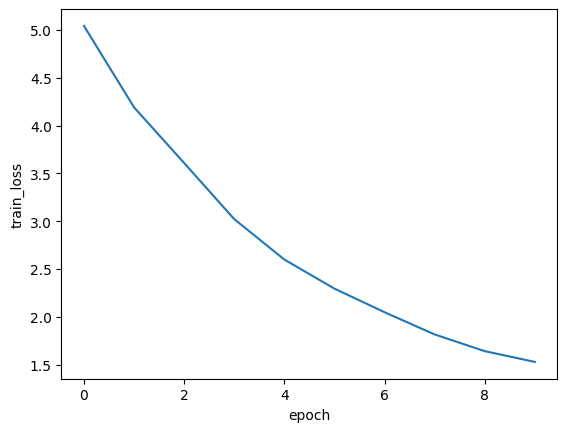

In [271]:
plt.xlabel('epoch')
plt.ylabel('train_loss')
plt.plot(epoch_list, train_loss_list)

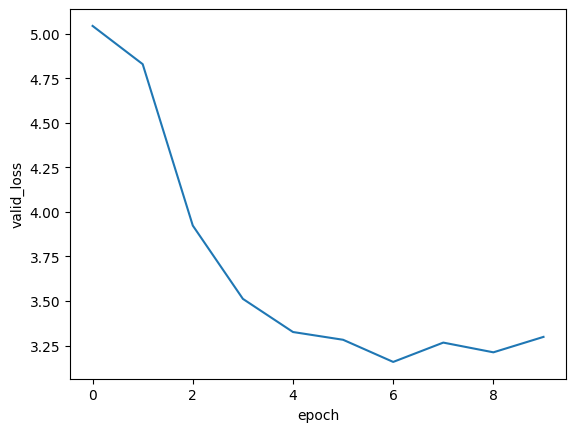

In [272]:
plt.xlabel('epoch')
plt.ylabel('valid_loss')
plt.plot(epoch_list, valid_loss_list)

Finally, we test the model on the test set using these "best" parameters.

In [273]:
model.load_state_dict(torch.load('tut3-model.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 3.158 | Test PPL:  23.524 |


We've improved on the previous model, but this came at the cost of doubling the training time.

In the next notebook, we'll be using the same architecture but using a few tricks that are applicable to all RNN architectures - packed padded sequences and masking. We'll also implement code which will allow us to look at what words in the input the RNN is paying attention to when decoding the output.

In [274]:
from torch import no_grad


def translator(evaluate_sentence):
    with torch.no_grad():
        
        sentence = (evaluate_sentence.lower())
        
        #tokenize german senetece
        tokens = tokenize_de(sentence)
        #insert sos token at start of sentence
        tokens.insert(0, SRC.init_token)
        tokens.append(SRC.eos_token)
        
        #convert words to numbers according to the vobaulary
        text_to_indices = [SRC.vocab.stoi[token] for token in tokens]
        print(text_to_indices)
        # Convert to Tensor
        sentence_tensor = torch.LongTensor(text_to_indices).unsqueeze(1).to(device)
        print(sentence_tensor)

        # Build encoder hidden, cell state
        with torch.no_grad():
            hidden, cell = model.encoder(sentence_tensor)
        
        #output begins with sos, so append it to the output
        outputs = [TRG.vocab.stoi["<sos>"]]
        
        #while predicting, the previous output is the input to the next step
        for _ in range(50):
            previous_word = torch.LongTensor([outputs[-1]]).to(device)

            with torch.no_grad():
                output, hidden, cell = model.decoder(previous_word, hidden, cell)
                best_guess = output.argmax(1).item()

            outputs.append(best_guess)
            
            # Model predicts it's the end of the sentence
            if output.argmax(1).item() == TRG.vocab.stoi["<eos>"]:
                break
        
        #convert the numbers to words using vocabulary
        translated_sentence = [TRG.vocab.itos[idx] for idx in outputs]
        print(translated_sentence[1:])

In [ ]:
model.load_state_dict(torch.load('C:/Users/dla12/Desktop/nlp_202202/pytorch-seq2seq-master/tut3-model.pt'))

test_loss = evaluate(model, test_iterator, criterion)
print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

#random.choice(test_clean)
test_file = open("./.data/multi30k/test2016.de")
test_sentences = []
for sentence in test_file:
    sentence = sentence.strip("\n")
    test_sentences.append(sentence.lower())
    
test_file.close()
test_file = open("./.data/multi30k/test2016.en")
ground_truth = []
for sentence in test_file:
    sentence = sentence.strip("\n")
    ground_truth.append(sentence.lower())
test_file.close()
#print(test_sentences[0:10])
i=0
while i<5:
    pair_choice = random.randint(0, 100)
    
    ground_truth_sen = ground_truth[pair_choice]
    ground_truth_sen = ground_truth_sen.lower()
    to_test = test_sentences[pair_choice]
    print("en",ground_truth_sen)
    print("dn",to_test)
    translator(to_test)
    print(ground_truth)
    i+=1